# Proposal

In [1]:
# Load Necessary Libaries:
library(broom)
library(tidyverse)
library(latex2exp)
library(repr)
library(digest)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(glmnet)
library(cowplot)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.0      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-4



## 1. Introduction:  
Air pollution has always been a major stressor to natural ecosystems and human health. Airborne particulate matter (PM) consists of a complex mixture of many chemical species, wherein PM 2.5 is particularly harmful due to its fine inhalable particles. Recent research states that long term exposure to PM2.5 will increase not only the cardiopulmonary problems but also the mortality of lung cancers (Xing, 2016). Due to this concern, our group have chosen the dataset that contains the hourly data of PM 2.5 concentration collected from the US Embassy in Beijing. The meteorological data from Beijing International Airport will also be included.

## 2. Explorative Data Analysis:  

The original dataset contains 13 variables; we rephrase `year`,`month`,`day`,`hour`,`No` as a new `time` variable to better fit a regression model. This leaves us with 9 variables of interest after cleaning the data up:
- `pm2.5`: PM2.5 concentration (ug/m^3)
- `DEWP`: Dew Point (â„ƒ)
- `TEMP`: Temperature (â„ƒ)
- `PRES`: Pressure (hPa)
- `cbwd`: Combined wind direction
- `Iws`: Cumulated wind speed (m/s)
- `Is`: Cumulated hours of snow
- `Ir`: Cumulated hours of rain
- `time`: an sequence of number from 1 to n whose order is defined by the pruned variables
  
Then, we take a simple random sample here with 1000 observations to estimate the population statistics of the variables of interest. 

In [2]:
set.seed(3)
### Load the entire data set into R frame & prune all NA rows
PM2.5_data <- read.csv(file = "https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv") %>%
              drop_na()
head(PM2.5_data)
### Data Cleaning: 
### remove the year, month, day, hour, No columns, instead represent the time & order of the observation by labeling them from 1 to n
PM2.5_data <- PM2.5_data %>%
              mutate(time = No - 24) %>%
              select(-c(No, year, month, day, hour))
head(PM2.5_data)
### take a sample of size n
n = 1000
PM2.5_sample <- PM2.5_data %>%
                sample_n(size = n, replace = FALSE) # we do not want replicated observations in our sample
head(PM2.5_sample)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>
1,25,2010,1,2,0,129,-16,-4,1020,SE,1.79,0,0
2,26,2010,1,2,1,148,-15,-4,1020,SE,2.68,0,0
3,27,2010,1,2,2,159,-11,-5,1021,SE,3.57,0,0
4,28,2010,1,2,3,181,-7,-5,1022,SE,5.36,1,0
5,29,2010,1,2,4,138,-7,-5,1022,SE,6.25,2,0
6,30,2010,1,2,5,109,-7,-6,1022,SE,7.14,3,0


,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,time
,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,<dbl>
1,129,-16,-4,1020,SE,1.79,0,0,1
2,148,-15,-4,1020,SE,2.68,0,0,2
3,159,-11,-5,1021,SE,3.57,0,0,3
4,181,-7,-5,1022,SE,5.36,1,0,4
5,138,-7,-5,1022,SE,6.25,2,0,5
6,109,-7,-6,1022,SE,7.14,3,0,6


,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,time
,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,<dbl>
1,50,12,27,1012,SE,27.25,0,0,23179
2,100,10,11,1014,NW,16.10,0,5,41610
3,18,1,14,1003,NW,17.88,0,0,20766
4,68,-16,3,1024,SE,5.37,0,0,43386
5,53,-20,7,1013,NW,147.50,0,0,35042
6,83,17,19,1008,SE,12.97,0,6,38480


### 2.1 Summary Statistics:  
The following table contains the values of estimators: mean, max, min, & standard deviation. We intend to use these estimator values to measure the spread & range of the continuous variables of intest.


In [3]:
### Calculate mean, max, min, SD for each variable present in the sample
pm2.5 <- PM2.5_sample %>%
         summarize(mean = mean(pm2.5), sd = sd(pm2.5), max = max(pm2.5), min = min(pm2.5))
DEWP <-  PM2.5_sample %>%
         summarize(mean = mean(DEWP), sd = sd(DEWP), max = max(DEWP), min = min(DEWP))
time <- PM2.5_sample %>%
         summarize(mean = mean(time), sd = sd(time), max = max(time), min = min(time))
TEMP <- PM2.5_sample %>%
        summarize(mean = mean(TEMP), sd = sd(TEMP), max = max(TEMP), min = min(TEMP))
PRES <- PM2.5_sample %>%
         summarize(mean = mean(PRES), sd = sd(PRES), max = max(PRES), min = min(PRES))
Iws <- PM2.5_sample %>%
         summarize(mean = mean(Iws), sd = sd(Iws), max = max(Iws), min = min(Iws))
Is <- PM2.5_sample %>%
         summarize(mean = mean(Is), sd = sd(Is), max = max(Is), min = min(Is))
Ir <- PM2.5_sample %>%
         summarize(mean = mean(Ir), sd = sd(Ir), max = max(Ir), min = min(Ir))
Summary_Statistics_Table <- data.frame(variables = c("pm2.5", "DEWP", "time", "TEMP", "PRES", "Iws", "Is", "Ir"),
                                        mean = c(pm2.5$mean, DEWP$mean, time$mean, TEMP$mean, PRES$mean, Iws$mean, Is$mean, Ir$mean),
                                        max = c(pm2.5$max, DEWP$max, time$max, TEMP$max, PRES$max, Iws$max, Is$max, Ir$max),
                                       min = c(pm2.5$min, DEWP$min, time$min, TEMP$min, PRES$min, Iws$min, Is$min, Ir$min),
                                      sd = c(pm2.5$sd, DEWP$sd, time$sd, TEMP$sd, PRES$sd, Iws$sd, Is$sd, Ir$sd))
Summary_Statistics_Table

variables,mean,max,min,sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
pm2.5,96.54800,649.00,2.00,8.954573e+01
DEWP,2.00200,26.00,-30.00,1.435124e+01
time,23073.40100,43782.00,48.00,1.275101e+04
TEMP,12.47300,37.00,-16.00,1.178593e+01
PRES,1016.23200,1045.00,993.00,1.013543e+01
Iws,23.49938,368.33,0.45,4.700688e+01
Is,0.06300,17.00,0.00,7.359161e-01
Ir,0.23300,31.00,0.00,1.656338e+00


### 2.2 Testing for Multicollinarity:  
Given that the multicollinearity present between input variables can affect both the estimates & especially the standard error associated with them, to detect the multicollinearity in our data, we take the following step to visualize the correlation between variables & calculate the VIF (variance inflation factor) for all possible input variables.

Warning message:
“'tidy.numeric' is deprecated.
See help("Deprecated")”


names,vif
<chr>,<dbl>
DEWP,3.621576
TEMP,4.689560
PRES,3.470609
cbwdNE,1.373627
cbwdNW,1.993390
cbwdSE,1.860855
Iws,1.268260
Is,1.033323
Ir,1.034762


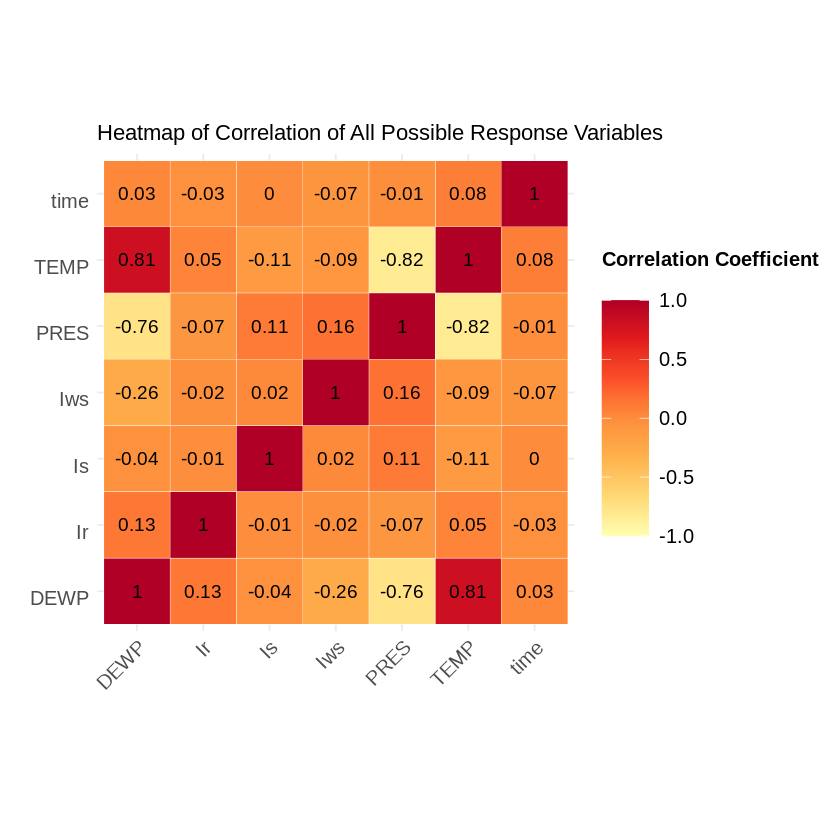

In [6]:
### Calculate Correlation for each pair of the continuous variable:
corr_matrix <- PM2.5_sample %>%
               select(- c("pm2.5", "cbwd")) %>% 
               cor() %>%
               as.data.frame() %>%
               rownames_to_column("var1") %>%
               pivot_longer(-var1, names_to = "var2", values_to = "corr")
### Visualisation using heatmap:
plot_corr_matrix <- corr_matrix %>%
   ggplot(aes(x = var1, y = var2)) +
   geom_tile(aes(fill = corr), color = "white") + 
   scale_fill_distiller("Correlation Coefficient \n",
     palette =  "YlOrRd",
     direction = 1, limits = c(-1, 1)
   ) +
   labs(x = "", y = "") +
   theme_minimal() +
   theme(
     axis.text.x = element_text(
       angle = 45, vjust = 1,
       size = 12, hjust = 1
     ),
     axis.text.y = element_text(
       vjust = 1,
       size = 12, hjust = 1
     ),
     legend.title = element_text(size = 12, face = "bold"),
     legend.text = element_text(size = 12),
     legend.key.size = unit(1, "cm")
   ) +
   coord_fixed() +
   geom_text(aes(var1, var2, label = round(corr, 2)), color = "black", size = 4) + 
   ggtitle("Heatmap of Correlation of All Possible Response Variables")
 plot_corr_matrix
### Calculate vif: 
MLR_pm2.5 <- lm(pm2.5 ~ ., data = PM2.5_sample)
VIF_pm2.5 <- vif(MLR_pm2.5)
vif_pm2.5_tidy <- tidy(VIF_pm2.5) %>%
                  mutate(vif = x) %>%
                  select(-x)
vif_pm2.5_tidy

As observed from the calculated vif values in the table above, `TEMP` variable has the highest vif value overall & is much greater than 1; thus, we might decide to prune this variable later in our project to address the multicollinearity problem in our data. 

# 3. Plan:  
Our group intends to make inference on the possible associations between the input variables (`DEWP`,`PRES`,`cbwd``Iws`,`Is`,`Ir`,`time`,`TEMP`) & the represonse varibale (`pm2.5`). To do so, we will perform the forward selection to find a good generative model with the largest adjusted $R^2$ found & use F-tests on different reduced models to test out the signifcance of each terms of our selected model. Then, we will focus on the quality of our results by testing the model against the linear regression assumptions (linarity, homoscedasticity, normality, etc.) & make adjustments when any violation is discovered. Finally, we will discuss on the limitation of our results & conclude our project by considering if any causality can be established from our inference. 

# 4. Reference:
1. Xing, Y.-F., Xu, Y.-H., Shi, M.-H., & Lian, Y.-X. (2016, January). The impact of PM2.5 on the human respiratory system. Journal of thoracic disease. Retrieved November 5, 2022, from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4740125/